[View in Colaboratory](https://colab.research.google.com/github/aksh98/FintechProject/blob/master/NowCastingData_Regression.ipynb)

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [0]:
!pip install -U -q PyDrive


In [0]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
creds = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving GoogleTrendsData.csv to GoogleTrendsData.csv
User uploaded file "GoogleTrendsData.csv" with length 4934 bytes


In [0]:
# !ls
!cd datalab


In [11]:
# %cd ..
!ls

adc.json  datalab  sample_data


In [6]:
datafile = pd.read_csv('GoogleTrendsData.csv')
datafile.shape

(176, 8)

In [7]:
# datafile.shape[0]
datafile.tail()

,Month,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
171,2018-04,74,18,1,4,13,68,127.0
172,2018-05,71,16,1,4,9,68,134.0
173,2018-06,71,17,1,3,9,71,132.0
174,2018-07,71,18,1,5,9,71,NaN
175,2018-08,85,16,1,5,11,81,NaN


In [0]:
# print(datafile['UMEX'].max())
# print(datafile['UMEX'].min())

datafile.drop(datafile.tail(2).index,inplace=True)

In [9]:
datafile.tail()

,Month,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
169,2018-02,72,20,1,5,27,63,136.0
170,2018-03,71,17,1,4,15,64,134.0
171,2018-04,74,18,1,4,13,68,127.0
172,2018-05,71,16,1,4,9,68,134.0
173,2018-06,71,17,1,3,9,71,132.0


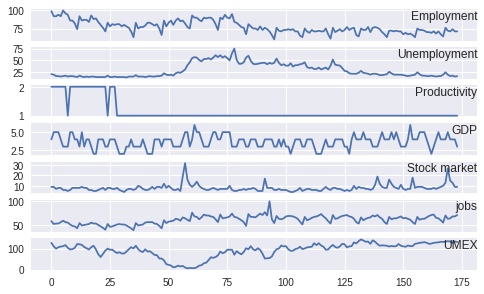

In [39]:
from matplotlib import pyplot
from pandas import concat


pyplot.figure()

for i in range(1,8):
  pyplot.subplot(8,1,i+1)
  pyplot.plot(datafile.values[:,i])
  pyplot.title(datafile.columns[i],y=0.5,loc='right')

# pyplot.subplot(7,1,7)
# pyplot.plot(datafile.values[:,0])
# pyplot.title(datafile.columns[0],y=0.5,loc='right')

pyplot.show()  

In [0]:
Y = datafile['UMEX']
X = datafile[['Employment','Unemployment','Productivity','GDP','Stock market','jobs']]
X.head()
print(X.shape, Y.shape)
# print(Y.values)

In [45]:
# remove month & year column

datafile = datafile[['Employment','Unemployment','Productivity','GDP','Stock market','jobs','UMEX']]
datafile.head()

,Employment,Unemployment,Productivity,GDP,Stock market,jobs,UMEX
0,99,21,2,4,9,58,128.0
1,92,20,2,5,9,52,111.0
2,92,17,2,5,7,53,100.0
3,94,17,2,5,8,53,107.0
4,92,16,2,4,8,56,110.0


---
# **Training Models**
---

In [49]:
#====================================================
##          Long Short Term Memory Data Preparation
#====================================================

# source: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

from sklearn.preprocessing import MinMaxScaler


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
values = datafile.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
# print(scaled)
reframed = series_to_supervised(scaled, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())




   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.975   0.114754        1.0       0.50   0.178571   0.311475   
2      0.800   0.098361        1.0       0.75   0.178571   0.213115   
3      0.800   0.049180        1.0       0.75   0.107143   0.229508   
4      0.850   0.049180        1.0       0.75   0.142857   0.229508   
5      0.800   0.032787        1.0       0.50   0.142857   0.278689   

   var7(t-1)  var1(t)  
1   0.884058     0.80  
2   0.760870     0.80  
3   0.681159     0.85  
4   0.731884     0.80  
5   0.753623     1.00  


In [51]:
values = reframed.values
train = values[:100,:]
test = values[100:,:]
train_x,train_y = train[:,:-1],train[:,-1]
test_x,test_y = test[:,:-1],test[:,-1]

train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

print(test_x.shape, test_y.shape, train_x.shape, train_y.shape)

(73, 1, 7) (73,) (100, 1, 7) (100,)


(73, 1, 7) (73,) (100, 1, 7) (100,)
Train on 100 samples, validate on 73 samples
Epoch 1/50
 - 1s - loss: 0.4654 - val_loss: 0.1729
Epoch 2/50
 - 0s - loss: 0.4105 - val_loss: 0.1293
Epoch 3/50
 - 0s - loss: 0.3564 - val_loss: 0.0913
Epoch 4/50
 - 0s - loss: 0.3008 - val_loss: 0.0748
Epoch 5/50
 - 0s - loss: 0.2492 - val_loss: 0.0968
Epoch 6/50
 - 0s - loss: 0.2096 - val_loss: 0.1323
Epoch 7/50
 - 0s - loss: 0.1800 - val_loss: 0.1698
Epoch 8/50
 - 0s - loss: 0.1621 - val_loss: 0.1997
Epoch 9/50
 - 0s - loss: 0.1521 - val_loss: 0.2192
Epoch 10/50
 - 0s - loss: 0.1472 - val_loss: 0.2283
Epoch 11/50
 - 0s - loss: 0.1452 - val_loss: 0.2303
Epoch 12/50
 - 0s - loss: 0.1440 - val_loss: 0.2287
Epoch 13/50
 - 0s - loss: 0.1432 - val_loss: 0.2255
Epoch 14/50
 - 0s - loss: 0.1426 - val_loss: 0.2214
Epoch 15/50
 - 0s - loss: 0.1420 - val_loss: 0.2170
Epoch 16/50
 - 0s - loss: 0.1415 - val_loss: 0.2125
Epoch 17/50
 - 0s - loss: 0.1410 - val_loss: 0.2080
Epoch 18/50
 - 0s - loss: 0.1405 - val_loss:

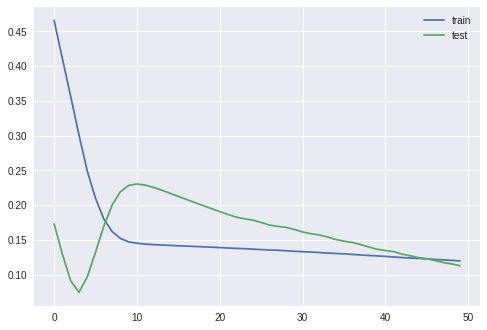

(73, 1, 7)
Test RMSE by LSTM : 5.314


In [66]:
#====================================================
##          Long Short Term Memory
#====================================================

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#--------------------------
values = reframed.values
train = values[:100,:]
test = values[100:,:]
train_x,train_y = train[:,:-1],train[:,-1]
test_x,test_y = test[:,:-1],test[:,-1]

train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

print(test_x.shape, test_y.shape, train_x.shape, train_y.shape)
#====================================================
##          Long Short Term Memory MODEL       ----
#====================================================

model = Sequential()
model.add(LSTM(50, input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam')
# fit network
history = model.fit(train_x,train_y,epochs=50,batch_size=16, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# plot
pyplot.plot(history.history['loss'],label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

#====================================================
##          Long Short Term Memory Prediction
#====================================================
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt

print(test_x.shape)

yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE by LSTM : %.3f' % rmse)

#====================================================
##          LSTM Model End
#====================================================


In [63]:
values = reframed.values
train = values[:100,:]
test = values[100:,:]
train_x,train_y = train[:,:-1],train[:,-1]
test_x,test_y = test[:,:-1],test[:,-1]

train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

print(test_x.shape, test_y.shape, train_x.shape, train_y.shape)

(73, 1, 7) (73,) (100, 1, 7) (100,)


test_Data  - predicted  - improved
108.0  ->  100.71   - 95.80
112.0  ->  119.02   - 100.41
19.0  ->  42.69   - 64.60
111.0  ->  119.02   - 123.57
112.0  ->  119.02   - 122.00
63.0  ->  90.69   - 88.31
123.0  ->  119.02   - 103.53
121.0  ->  100.71   - 105.79
18.0  ->  73.47   - 31.45
124.0  ->  119.02   - 116.33
11.0  ->  73.47   - 64.36
127.0  ->  119.02   - 120.43
86.0  ->  73.47   - 64.36
26.0  ->  79.46   - 97.35
134.0  ->  119.02   - 124.06
92.0  ->  90.69   - 87.39
95.0  ->  79.46   - 78.15
97.0  ->  79.46   - 86.55
101.0  ->  90.69   - 88.31
101.0  ->  90.69   - 89.96
118.0  ->  100.71   - 94.71
71.0  ->  73.47   - 71.34
112.0  ->  119.02   - 120.43
23.0  ->  100.71   - 75.92
134.0  ->  73.47   - 107.16
112.0  ->  119.02   - 115.50
98.0  ->  119.02   - 97.29
140.0  ->  119.02   - 116.33
112.0  ->  42.69   - 84.09
7.0  ->  73.47   - 71.51
107.0  ->  86.25   - 85.71
8.0  ->  90.69   - 86.73
111.0  ->  90.69   - 87.06
104.0  ->  79.46   - 88.86
107.0  ->  100.71   - 105.14


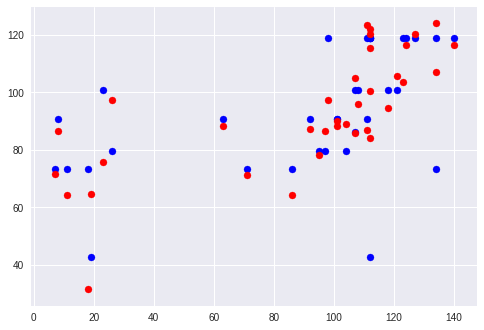

In [179]:
#====================================================
##          Regression Models
#====================================================

rng = np.random.RandomState(1)

# reg = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
# regr_2 = AdaBoostRegressor(SVR(kernel= 'rbf', C= 1e3, gamma= 0.1),
#                           n_estimators=300, random_state=rng)
reg = DecisionTreeRegressor(max_depth=3)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3),
                          n_estimators=300, random_state=rng)

# reg = LinearRegression()
# reg = SVR(kernel='rbf',)
reg.fit(X_train,Y_train)
regr_2.fit(X_train,Y_train)

arr = reg.predict(X_test)
arr2 = regr_2.predict(X_test)


# print(reg.coef_)
# print(reg.intercept_)


# tsne = TSNE(n_components=2).fit_transform(X)
# print("tsne shape - ",tsne.shape)
# plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
# plt.title('Testing Data')
# plt.xticks(())
# plt.yticks(())
# plt.plot(test,reg.predict(X_test),color = 'red',linewidth=3)
# plt.show()


test = np.asarray(Y_test) # to print


print("test_Data"," - predicted"," - improved")

for i in range(0,len(Y_test)):
  print(test[i]," ->  %.2f"%arr[i],"  - %.2f"%arr2[i])

plt.scatter(test,arr,color='blue')
plt.scatter(test,arr2,color='red')
plt.show()

test_Data - predicted - improved
108.0  ->  95.88   - 90.84
112.0  ->  103.77   - 103.34
19.0  ->  88.74   - 87.18
111.0  ->  97.08   - 93.07
112.0  ->  91.19   - 89.34
63.0  ->  94.32   - 90.64
123.0  ->  108.30   - 103.21
121.0  ->  105.20   - 99.14
18.0  ->  91.16   - 89.30
124.0  ->  111.59   - 107.46
11.0  ->  90.92   - 89.15
127.0  ->  103.88   - 97.16
86.0  ->  90.70   - 88.97
26.0  ->  86.05   - 86.54
134.0  ->  116.53   - 109.59
92.0  ->  105.41   - 94.22
95.0  ->  50.00   - 60.43
97.0  ->  74.58   - 81.14
101.0  ->  93.87   - 91.88
101.0  ->  93.73   - 90.73
118.0  ->  96.62   - 88.85
71.0  ->  91.16   - 89.30
112.0  ->  99.78   - 96.24
23.0  ->  75.58   - 74.87
134.0  ->  104.50   - 101.35
112.0  ->  108.06   - 107.55
98.0  ->  93.32   - 96.06
140.0  ->  97.58   - 94.63
112.0  ->  94.97   - 92.65
7.0  ->  88.09   - 86.67
107.0  ->  108.16   - 103.88
8.0  ->  90.25   - 89.13
111.0  ->  98.47   - 96.95
104.0  ->  65.81   - 70.40
107.0  ->  100.70   - 96.66


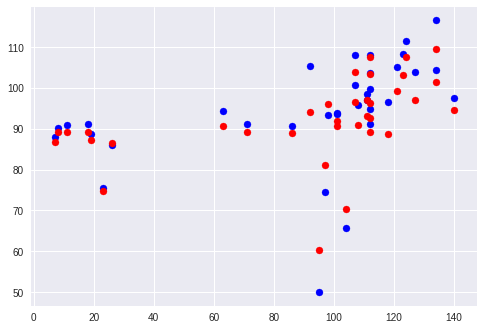

In [180]:
#====================================================
##          Regression Models
#====================================================

rng = np.random.RandomState(1)

reg = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
regr_2 = AdaBoostRegressor(SVR(kernel= 'rbf', C= 1e3, gamma= 0.1),
                          n_estimators=300, random_state=rng)

# reg = LinearRegression()
# reg = SVR(kernel='rbf',)
reg.fit(X_train,Y_train)
regr_2.fit(X_train,Y_train)

arr = reg.predict(X_test)
arr2 = regr_2.predict(X_test)


# print(reg.coef_)
# print(reg.intercept_)


# tsne = TSNE(n_components=2).fit_transform(X)
# print("tsne shape - ",tsne.shape)
# plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
# plt.title('Testing Data')
# plt.xticks(())
# plt.yticks(())
# plt.plot(test,reg.predict(X_test),color = 'red',linewidth=3)
# plt.show()


test = np.asarray(Y_test) # to print


print("test_Data","- predicted","- improved")

for i in range(0,len(Y_test)):
  print(test[i]," ->  %.2f"%arr[i],"  - %.2f"%arr2[i])

plt.scatter(test,arr,color='blue')
plt.scatter(test,arr2,color='red')
plt.show()

[-1.50861042 -0.94813394  0.69087487 -1.6366327   0.99295168  0.71399944]
204.0330738506069
tsne shape -  (174, 2)


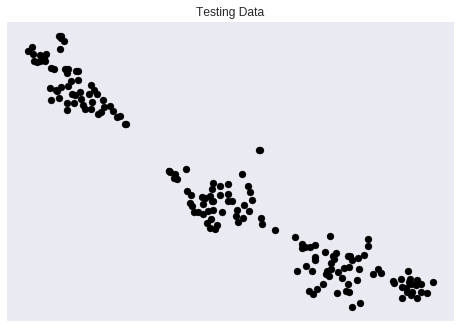

123.0  -> 121.43
115.0  -> 125.03
79.0  -> 82.40
70.0  -> 100.73
111.0  -> 94.62
7.0  -> 51.41
92.0  -> 91.40
73.0  -> 84.78
60.0  -> 62.47
121.0  -> 78.00
90.0  -> 97.58
63.0  -> 99.53
45.0  -> 59.94
133.0  -> 110.29
95.0  -> 45.77
96.0  -> 88.57
21.0  -> 68.98
83.0  -> 97.60
94.0  -> 92.97
117.0  -> 76.66
11.0  -> 102.25
129.0  -> 125.89
108.0  -> 96.11
114.0  -> 106.53
114.0  -> 112.18
53.0  -> 108.68
126.0  -> 106.70
101.0  -> 88.96
97.0  -> 81.30
104.0  -> 96.39
116.0  -> 116.32
109.0  -> 123.13
97.0  -> 99.27
133.0  -> 99.04
84.0  -> 103.26


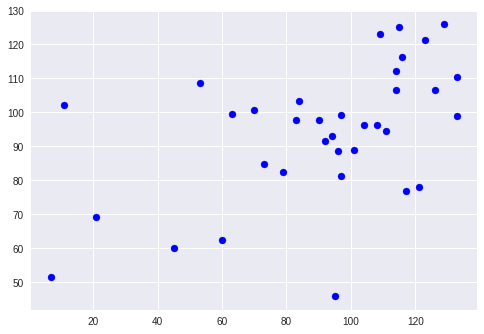

In [155]:
#====================================================
##          Bayesian Ridge Model
#====================================================

regr = linear_model.BayesianRidge()
regr.fit(X_train,Y_train)
print(regr.coef_)
print(regr.intercept_)

tsne = TSNE(n_components=2).fit_transform(X)
print("tsne shape - ",tsne.shape)

plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
plt.title('Testing Data')
plt.xticks(())
plt.yticks(())
# plt.plot(Y_test,reg.predict(X_test),color = 'red',linewidth=3)
plt.show()

test = np.asarray(Y_test)
arr = regr.predict(X_test)
for i in range(0,len(Y_test)):
  print(test[i]," -> %.2f"%arr[i])
  
plt.scatter(test,arr,color='blue')
plt.show()

(174, 6)
tsne shape -  (174, 2)


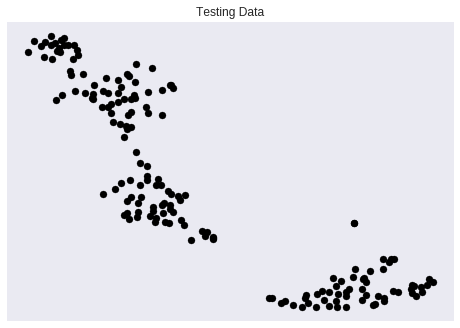

In [26]:
#====================================================
##          Component Reduction
#====================================================

# X.head()
print(X.shape)

tsne = TSNE(n_components=2).fit_transform(X)
print("tsne shape - ",tsne.shape)

plt.scatter(tsne[:,0],tsne[:,1],color = 'black')
plt.title('Testing Data')
plt.xticks(())
plt.yticks(())
plt.show()
